### Final Project in Bayesian Data Analysis

# A hierarchical Poisson model for the prediction of football results


## !!! IMPORTANT !!! 
The pdf version of this notebook is badly formatted due to unnatural page separations and some missing images, which could not be rendered. This was an issue with the pdf conversion that I could not fix. I therefore reckommend the reader, if possible, to view the notebook in Jupyter. It can be found in the following Github repository: https://github.com/Augustegm/BDA02936_FinalProject

## 1. Introduction
Using probabilistic models to determine the outcome of sports events is a problem that attracts immense interest in many communities. In this notebook we implement a hierarchical Poisson model for the prediction of football results and apply it to the Italy Series A 1991-1992. We further assess the quality of the model by comparing it to two models inspired by the hierarchical Poisson model but with simplifying assumptions. The comparison is made by assessing their predictivive performances on the Italy Series A 1991-1992 as well as through leave-one-out cross-validation.

## 2. The Data Set
The data set for the Italy series A 1991-1992 used in this study is taken from https://www.worldfootball.net/schedule/ita-serie-a-1991-1992-spieltag/ through the use of the script webscraper.py, which is included in the Github repository https://github.com/Augustegm/BDA02936_FinalProject. The webscraper collects the data from the above website through an html-parser and writes it to the file data.pickle. The code below will load the data set and sort it in to the relevant variables.  

In [1]:
#Import relevant modules
import pystan
import pylab as plt
import numpy as np
from bs4 import BeautifulSoup
import urllib.request
import pickle
from psis import psisloo

In [2]:
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)

y1 = data['home_goals']
y2 = data['away_goals']
home_teams = data['home_team']
away_teams = data['away_team']
g = np.arange(1,len(y1)+1)
ordered_teams = list(set(home_teams))
ordered_teams.sort()
N = len(home_teams)
N_teams = len(ordered_teams)
N_games_per_team = (N_teams-1)*2 
h = []
a = []


for home_team, away_team in zip(home_teams,away_teams):
    h.append(ordered_teams.index(home_team)+1)
    a.append(ordered_teams.index(away_team)+1)


football_data = {'N': np.array(N),
               'N_teams': np.array(N_teams),
               'y1': np.array(y1),
               'y2': np.array(y2), 
                'h': np.array(h),
                'a': np.array(a)}

print('List of teams in alphabetical order:')
for team in ordered_teams:
    print(team)

List of teams in alphabetical order:
ACFFiorentina
ACMilan
ASBari
ASRoma
AscoliCalcio
Atalanta
CagliariCalcio
GenoaCFC
HellasVerona
Inter
Juventus
LazioRoma
ParmaAC
SSCNapoli
Sampdoria
TorinoFC
USCremonese
USFoggia


## 3. Hierarchical Poisson Model

### 3.1 Model description
We will start by investigating our main model, which is a hierarchical Poisson model originally proposed by [1], and whose diagrammatic representation can be seen in the figure below. The core assumption of the model is that the number of goals for the home (j=1) or away (j=2) team in game g of the season may be modelled as independently Poisson distributed according to:

$y_{g1} \lvert \theta_{g1} \sim \text{Poisson}(\theta_{g1}), \\
y_{g2} \lvert \theta_{g2} \sim \text{Poisson}(\theta_{g2}).$

Thus, within this model, the parameters $\theta_{gj}$ describe the scoring intensity of the team playing at home or away in the g'th game. These parameters are assumed to follow a loglinear random effect model according to:

$\text{log}\theta_{g1} = \text{home} + \text{att}_{h(g)} + \text{def}_{a(g)} , \\
\text{log}\theta_{g2} = \text{att}_{a(g)} + \text{def}_{h(g)}.$

The parameters att and def denote the attack and defense abilities of the playing teams, and the nested indices a(g) and h(g) are used to identify the team playing at home or away in a particular game, g. The parameter home denotes the home advantage for the host team, which is assumed constant throughout all teams and games and to follow a flat prior distribution: 

$\text{home} \sim \text{Normal}(0, 10000)$.

In line with a typical hierarchical approach the parameters att and def are assumed to be exchangeable and drawn from a common distribution:

$  
\text{att}_{t} \sim \text{Normal}(\mu_{\text{att}}, \sigma_{\text{att}}), \\
\text{def}_{t} \sim \text{Normal}(\mu_{\text{def}}, \sigma_{\text{def}}),
$


where t denotes a specific team and the hyperparameters are assumed to have flat priors:

$
\mu_{\text{att}} \sim \text{Normal}(0, 10000), \\
\sigma_{\text{att}} \sim \text{Gamma}(0.1, 0.1), \\
\mu_{\text{def}} \sim \text{Normal}(0, 10000), \\
\sigma_{\text{def}} \sim \text{Gamma}(0.1, 0.1).
$

Finally, as an identifiability constraint on the team-specific parameters, we use the following sum-to-zero constraints:

$
\sum_{t} \text{att}_{t} = 0, \\
\sum_{t} \text{def}_{t} = 0.
$

, where the sum runs over all teams in the league (for the Italy series A 1991-1992 t= 1,2,3...,18).

<img src="Model.png" width = "700" title="Hierarchical Poisson Model">


### 3.2 Model implementation
Our STAN-implementation of the hierarchical Poisson model is shown in the following cells. To check that our implementation makes sense it is interesting to compare the values of the the team specific parameters to those obtained in the original paper of [1]. A table based on the values printed from our STAN fit and parameters obtained by [1] (shown in parenthesis) is seen below. Evidently the agreement is very good. From the table one can observe that there is a positive value associated with the home parameter and that well-performing teams, i.e. teams who are likely to score goals and unlikely to concede goals, are associated with a high value of the attack and low value of the defensive parameter, respectively.
<img src="table.png" width = "700" title="Comparison of our implementation with that of [1].">

                  
                  

In [3]:
#Stan code
stan_code = """
data {
int N; // number of observation points (306 games)
int N_teams; //number of unique teams (18)
int y1[N]; // vector of observed home goals 
int y2[N]; // vector of observed away goals
int h[N]; //indices for home teams
int a[N]; //indices for away teams
}

parameters {
vector[N_teams] att_uncond; // vector of attack values for the 18 teams without sum-to-zero constraint
vector[N_teams] def_uncond; // vector of defence values for the 18 teams without sum-to-zero constraint
real home; //constant home advantage across all teams
real mu_att;
real<lower=0> sigma_att;
real mu_def;
real<lower=0> sigma_def;
}


transformed parameters {
vector<lower=0>[N] theta1;
vector<lower=0>[N] theta2;
vector[N_teams] att; // vector of attack values for the 18 teams
vector[N_teams] def; // vector of defence values for the 18 teams

for (i in 1:N_teams){
att[i] = att_uncond[i] - mean(att_uncond);
def[i] = def_uncond[i] - mean(def_uncond);
}

for (i in 1:N){
theta1[i] = exp(home + att[h[i]] + def[a[i]]);
theta2[i] = exp(att[a[i]] + def[h[i]]);
}

}


model {

home ~ normal(0, 10000);
mu_att ~ normal(0, 10000);
sigma_att ~ gamma(0.1, 0.1);
mu_def ~ normal(0, 10000);
sigma_def ~ gamma(0.1,0.1);

for (i in 1:N_teams){
att_uncond[i] ~ normal(mu_att, sigma_att);
def_uncond[i] ~ normal(mu_def, sigma_def);
}

for (i in 1:N){
y1[i] ~ poisson(theta1[i]);
y2[i] ~ poisson(theta2[i]);
}

}


generated quantities {
vector[N] y1_pred;
vector[N] y2_pred;
vector[N] log_lik;
for (i in 1:N){
    log_lik[i] = poisson_lpmf(y1[i] | theta1[i]) + poisson_lpmf(y2[i] | theta2[i]);
    y1_pred[i] = poisson_rng(theta1[i]);
    y2_pred[i] = poisson_rng(theta2[i]);}


}

"""

#Compile Stan code and make fit
sm = pystan.StanModel(model_code=stan_code)
fit_model1 = sm.sampling(data=football_data, control={"adapt_delta" : 0.99, "max_treedepth": 16})
#print(fit_model1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_95c4575c91359f85f30383b7a931af4c NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## 4. Non-hierarchical Poisson Model

### 4.1 Model description
We now investigate a model very similar to the hierarchical Poisson model, but with the simplification that we neglect the highest hierarchy of hyperparameters in Figure 1. Consequently this model does not have a higher level coupling between the team-specific parameters as the hierarchical Poisson model. Mathematically this simplication simply means, that instead of assuming that the the values att and def are exchangeable and drawn from a common normal distribution, we instead assume that these have flat prior distributions:

$  
\text{att}_{t} \sim \text{Normal}(0, 10000), \\
\text{def}_{t} \sim \text{Normal}(0, 10000).
$

### 4.2 Model implementation
Our STAN-implementation of the non-hierarchical Poisson model is shown in the following cells.

In [4]:
#Stan code
stan_code = """
data {
int N; // number of observation points (306 games)
int N_teams; //number of unique teams (18)
int y1[N]; // vector of observed home goals 
int y2[N]; // vector of observed away goals
int h[N]; //indices for home teams
int a[N]; //indices for away teams
}

parameters {
vector[N_teams] att_uncond; // vector of attack values for the 18 teams without sum-to-zero constraint
vector[N_teams] def_uncond; // vector of defence values for the 18 teams without sum-to-zero constraint
real home; //constant home advantage across all teams*
}


transformed parameters {
vector<lower=0>[N] theta1;
vector<lower=0>[N] theta2;
vector[N_teams] att; // vector of attack values for the 18 teams
vector[N_teams] def; // vector of defence values for the 18 teams

for (i in 1:N_teams){
att[i] = att_uncond[i] - mean(att_uncond);
def[i] = def_uncond[i] - mean(def_uncond);
}

for (i in 1:N){
theta1[i] = exp(home + att[h[i]] + def[a[i]]);
theta2[i] = exp(att[a[i]] + def[h[i]]);
}

}


model {


home ~ normal(0, 10000);

for (i in 1:N_teams){
att_uncond[i] ~ normal(0, 1000);
def_uncond[i] ~ normal(0, 1000);
}

for (i in 1:N){
y1[i] ~ poisson(theta1[i]);
y2[i] ~ poisson(theta2[i]);
}

}


generated quantities {
vector[N] y1_pred;
vector[N] y2_pred;
vector[N] log_lik;
for (i in 1:N){
    log_lik[i] = poisson_lpmf(y1[i] | theta1[i]) + poisson_lpmf(y2[i] | theta2[i]);
    y1_pred[i] = poisson_rng(theta1[i]);
    y2_pred[i] = poisson_rng(theta2[i]);}

}

"""

#Compile Stan code and make fit
sm = pystan.StanModel(model_code=stan_code)
fit_model2 = sm.sampling(data=football_data, control={"adapt_delta" : 0.99, "max_treedepth": 20})
#print(fit_model2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4bb78dd9dd96b1dc4a2ff3bf41546e5c NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## 5. Simple Poisson Model

Our final model is once again inspired by the hierarchical Poisson model but this time with huge simplifications. For the simple Poisson model we simply assume that the number of goals scored by a team t playing at home (j=1) or away (j=2) is Poisson distributed:

$
y_{tj}\lvert \theta_{tj} \sim \text{Poisson}(\theta_{tj}).
$

Therefore, within this simple model, there are two Poisson parameters for a given team, describing their propensity to score when playing at home or away, and all interaction between the individual teams is neglected. The Poisson parameters are assumed to have flat priors:

$
\theta_{tj} \sim \text{Gamma}(0.1, 0.1).
$

### 4.2 Model implementation
Our STAN-implementation of this simple Poisson model is shown in the following cells.


In [5]:
#Stan code
stan_code = """
data {
int N; // number of observation points (306 games)
int N_teams; //number of unique teams (18)
int y1[N]; // vector of observed home goals 
int y2[N]; // vector of observed away goals
int h[N]; //indices for home teams
int a[N]; //indices for away teams
}

parameters {
vector<lower=0>[N_teams] theta1;
vector<lower=0>[N_teams] theta2;
}



model {

for (i in 1:N_teams){
theta1[i] ~ gamma(0.1, 0.1);
theta2[i] ~ gamma(0.1, 0.1);
}

for (i in 1:N){
y1[i] ~ poisson(theta1[h[i]]);
y2[i] ~ poisson(theta2[a[i]]);
}

}



generated quantities {
vector[N] y1_pred;
vector[N] y2_pred;
vector[N] log_lik;
for (i in 1:N){
    log_lik[i] = poisson_lpmf(y1[i] | theta1[h[i]]) + poisson_lpmf(y2[i] | theta2[a[i]]);
    y1_pred[i] = poisson_rng(theta1[h[i]]);
    y2_pred[i] = poisson_rng(theta2[a[i]]);}


}

"""

#Compile Stan code and make fit
sm = pystan.StanModel(model_code=stan_code)
fit_model3 = sm.sampling(data=football_data, control={"adapt_delta" : 0.99})
#print(fit_model3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_de9cf675d8a5dafd0579371f6b603cea NOW.


## 6 Predicting accumulated points throughout season
As a first comparison of our three models, we evaluate their predictive performance on the Italy series A 1991-1992. To do this we simulate 1000 outcomes of the Italy series A 1991-1992 for each model and calculate the mean number of accumulated points throughout the season for each team. These are then compared to the actual accumulated number of points observed in the Italy series A 1991-1992 season. This kind of comparison might seem strange given that the models were fitted to that exact data set. Nevertheless, we expect it to provide a good indication of the predictive performance of the individual models and their shortcomings. The comparison is done in the cells below using the random draws generated in the STAN codes above. The first set of figures display the predictions of the three models plotted against the number of accumulated points for each team. The second set of figure display the predictions for each model along with the 95% confidence interval of the predictions. Evidently, model 1 and 2 both do reasonably well while the simple Poisson model seems to be off in quite a lot of cases. Another interesting point to observe is that both model 1 and 2 appear to perform best for mediocre teams, i.e. teams which were not in the very top or very bottom in that season. As discussed in [1], this is in fact a common problem with these types of models, which is referred to as overshrinkage - the effect that all predictions are drawn towards the mean. In the works of [1] solutions to the problem of overshrinkage are explored, but this is beyond the scope of our simple study.  

In [6]:
#some plot options
percentage1, percentage2 = 5,95 #confidence interval for errorbars

#Function that assigns points based on score
def points(y1,y2):
    if y1>y2:
        points1, points2 = 2, 0
    elif y2>y1:
        points1, points2 = 0, 2
    else:
        points1, points2 = 1, 1
        
    return points1, points2

In [7]:
#Start by getting the actual accumulated points for each team throughout the season
actual_scores = np.zeros([N_teams, N_games_per_team], dtype = int)
actual_accumulated_points = np.zeros([N_teams, N_games_per_team], dtype = int)
count = np.zeros(N_teams, dtype = int)
for j in range(len(y1)):
        points1, points2 = points(y1[j],y2[j])
        count[h[j]-1] = count[h[j]-1] + 1
        count[a[j]-1] = count[a[j]-1] + 1
        actual_scores[h[j]-1, count[h[j]-1]-1] = points1 
        actual_scores[a[j]-1, count[a[j]-1]-1] = points2 
        actual_accumulated_points[h[j]-1, count[h[j]-1]-1] = np.sum(actual_scores[h[j]-1, :])
        actual_accumulated_points[a[j]-1, count[a[j]-1]-1] = np.sum(actual_scores[a[j]-1, :])

In [8]:
#Get Model 1 predictions

y1_pred = fit_model1.extract('y1_pred')['y1_pred']
y2_pred = fit_model1.extract('y2_pred')['y2_pred']
scores = np.zeros([N_teams, N_games_per_team, y1_pred.shape[0]], dtype = int)
accumulated_points = np.zeros([N_teams, N_games_per_team, y1_pred.shape[0]], dtype = int)


for i in range(y1_pred.shape[0]):
    count = np.zeros(N_teams, dtype = int)
    for j in range(y1_pred.shape[1]):
        points1, points2 = points(y1_pred[i,j],y2_pred[i,j])
        count[h[j]-1] = count[h[j]-1] + 1
        count[a[j]-1] = count[a[j]-1] + 1
        scores[h[j]-1, count[h[j]-1]-1, i] = points1 
        scores[a[j]-1, count[a[j]-1]-1, i] = points2 
        accumulated_points[h[j]-1, count[h[j]-1]-1, i] = np.sum(scores[h[j]-1, :, i])
        accumulated_points[a[j]-1, count[a[j]-1]-1, i] = np.sum(scores[a[j]-1, :, i])
        
lower_percentile1 = np.zeros([N_teams, N_games_per_team])
upper_percentile1 = np.zeros([N_teams, N_games_per_team])

for i in range(N_teams):
    for j in range(N_games_per_team):
        lower_percentile1[i,j] = np.percentile(accumulated_points[i,j,:],percentage1)
        upper_percentile1[i,j] = np.percentile(accumulated_points[i,j,:],percentage2)
teams = np.arange(N_teams)
mean_accumulated_points1 = np.mean(accumulated_points, axis = 2)

In [9]:
#Get Model 2 predictions

y1_pred = fit_model2.extract('y1_pred')['y1_pred']
y2_pred = fit_model2.extract('y2_pred')['y2_pred']
scores = np.zeros([N_teams, N_games_per_team, y1_pred.shape[0]], dtype = int)
accumulated_points = np.zeros([N_teams, N_games_per_team, y1_pred.shape[0]], dtype = int)


for i in range(y1_pred.shape[0]):
    count = np.zeros(N_teams, dtype = int)
    for j in range(y1_pred.shape[1]):
        points1, points2 = points(y1_pred[i,j],y2_pred[i,j])
        count[h[j]-1] = count[h[j]-1] + 1
        count[a[j]-1] = count[a[j]-1] + 1
        scores[h[j]-1, count[h[j]-1]-1, i] = points1 
        scores[a[j]-1, count[a[j]-1]-1, i] = points2 
        accumulated_points[h[j]-1, count[h[j]-1]-1, i] = np.sum(scores[h[j]-1, :, i])
        accumulated_points[a[j]-1, count[a[j]-1]-1, i] = np.sum(scores[a[j]-1, :, i])
        
lower_percentile2 = np.zeros([N_teams, N_games_per_team])
upper_percentile2 = np.zeros([N_teams, N_games_per_team])

for i in range(N_teams):
    for j in range(N_games_per_team):
        lower_percentile2[i,j] = np.percentile(accumulated_points[i,j,:],percentage1)
        upper_percentile2[i,j] = np.percentile(accumulated_points[i,j,:],percentage2)
teams = np.arange(N_teams)
mean_accumulated_points2 = np.mean(accumulated_points, axis = 2)

In [10]:
#Get Model 3 predictions

y1_pred = fit_model3.extract('y1_pred')['y1_pred']
y2_pred = fit_model3.extract('y2_pred')['y2_pred']
scores = np.zeros([N_teams, N_games_per_team, y1_pred.shape[0]], dtype = int)
accumulated_points = np.zeros([N_teams, N_games_per_team, y1_pred.shape[0]], dtype = int)


for i in range(y1_pred.shape[0]):
    count = np.zeros(N_teams, dtype = int)
    for j in range(y1_pred.shape[1]):
        points1, points2 = points(y1_pred[i,j],y2_pred[i,j])
        count[h[j]-1] = count[h[j]-1] + 1
        count[a[j]-1] = count[a[j]-1] + 1
        scores[h[j]-1, count[h[j]-1]-1, i] = points1 
        scores[a[j]-1, count[a[j]-1]-1, i] = points2 
        accumulated_points[h[j]-1, count[h[j]-1]-1, i] = np.sum(scores[h[j]-1, :, i])
        accumulated_points[a[j]-1, count[a[j]-1]-1, i] = np.sum(scores[a[j]-1, :, i])
        
lower_percentile3 = np.zeros([N_teams, N_games_per_team])
upper_percentile3 = np.zeros([N_teams, N_games_per_team])

for i in range(N_teams):
    for j in range(N_games_per_team):
        lower_percentile3[i,j] = np.percentile(accumulated_points[i,j,:],percentage1)
        upper_percentile3[i,j] = np.percentile(accumulated_points[i,j,:],percentage2)
mean_accumulated_points3 = np.mean(accumulated_points, axis = 2)

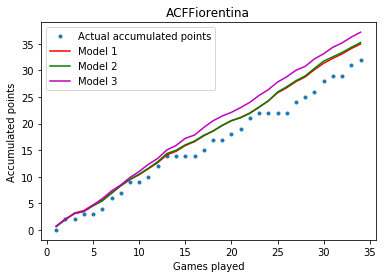

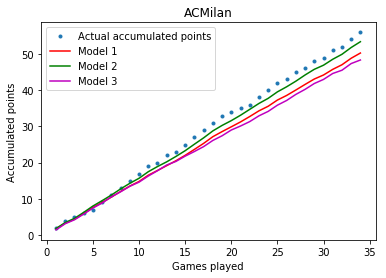

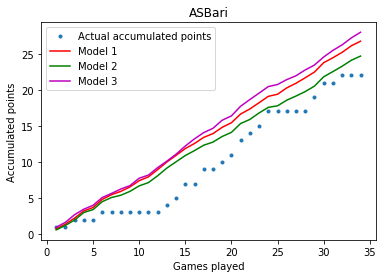

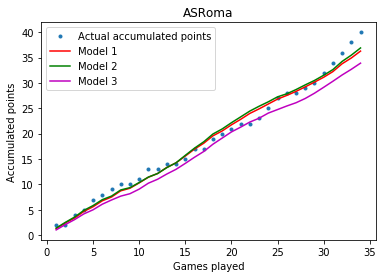

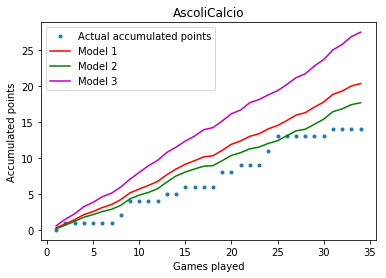

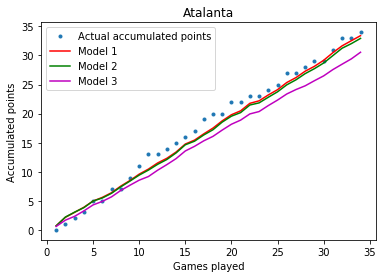

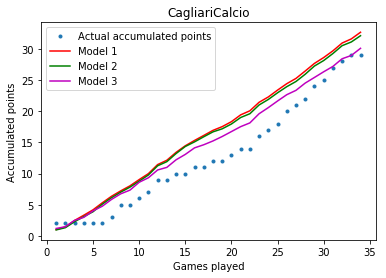

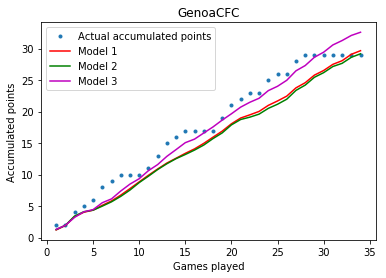

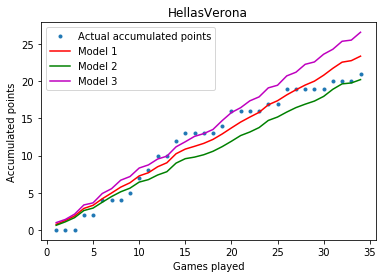

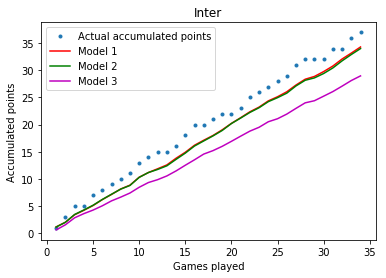

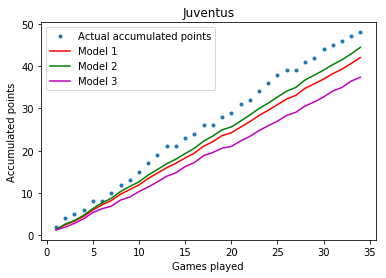

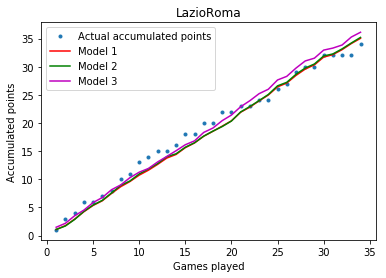

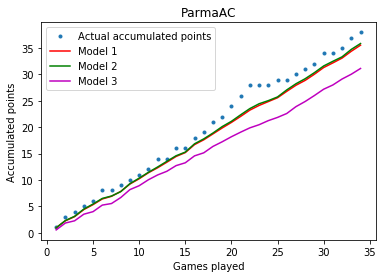

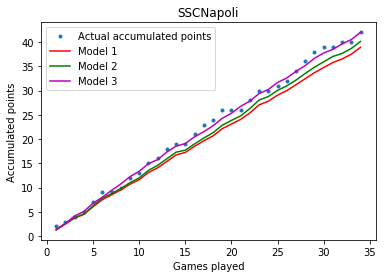

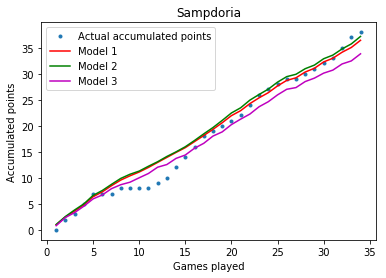

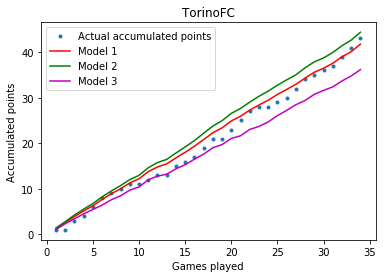

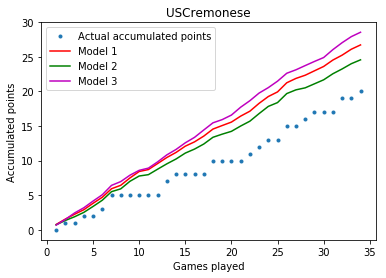

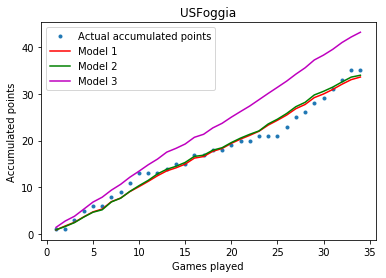

In [11]:
# Plot results

games_played = np.arange(1,N_games_per_team+1)

for i in np.arange(N_teams):
    
    #Actual score   
    plt.plot(games_played, actual_accumulated_points[i, :], '.', label = 'Actual accumulated points')
    
    #Model 1 predictions
    plt.plot(games_played, mean_accumulated_points1[i,:], color = 'r', label = 'Model 1')
    #plt.fill_between(games_played, lower_percentile1[i,:], upper_percentile1[i,:], color = 'r', alpha = 0.2)

    #Model 2 predictions
    plt.plot(games_played, mean_accumulated_points2[i,:], color = 'g', label = 'Model 2')
    #plt.fill_between(games_played, lower_percentile2[i,:], upper_percentile2[i,:], color = 'g', alpha = 0.2)
   
    #Model 3 predictions
    plt.plot(games_played, mean_accumulated_points3[i,:], color = 'm', label = 'Model 3')
    #plt.fill_between(games_played, lower_percentile3[i,:], upper_percentile3[i,:], color = 'm', alpha = 0.2)

    
    plt.xlabel('Games played')
    plt.ylabel('Accumulated points')
    plt.legend()
    plt.title(ordered_teams[i])
    plt.show()

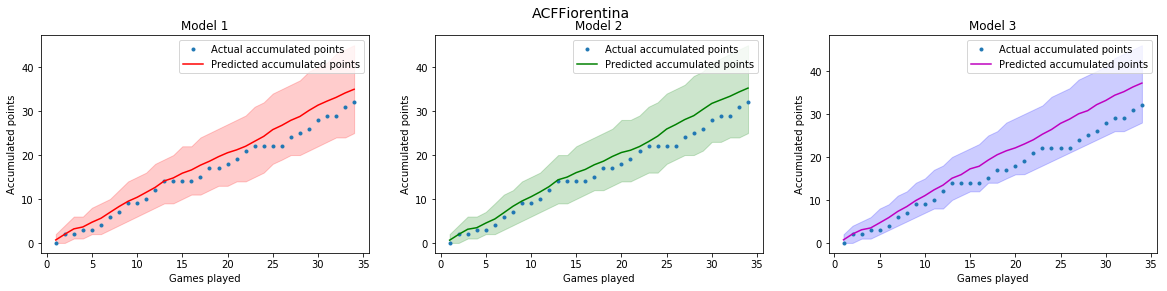

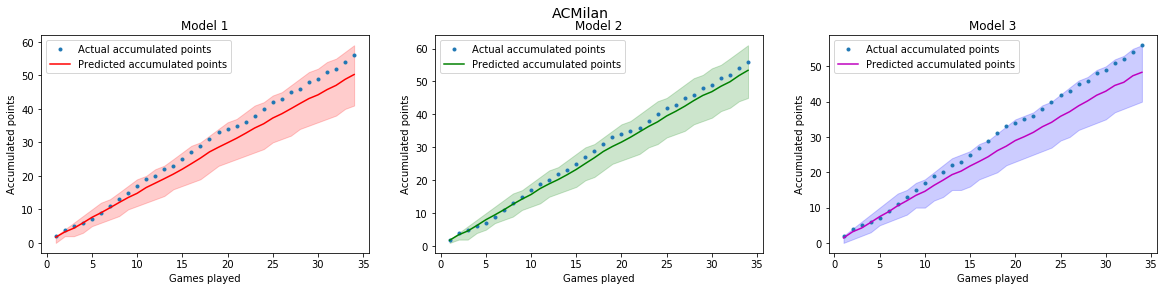

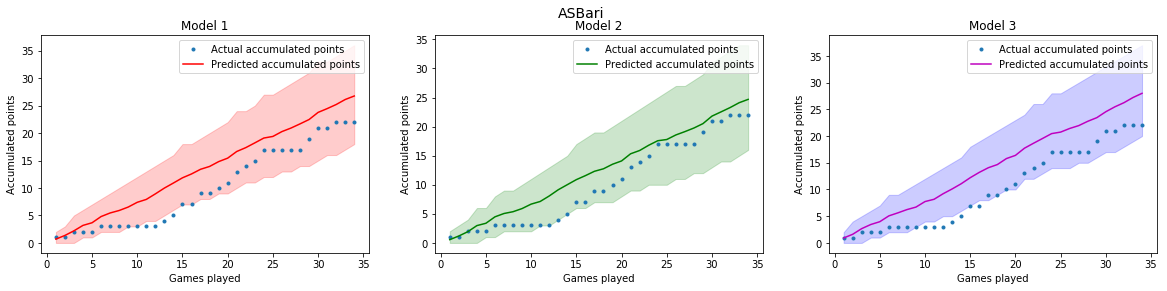

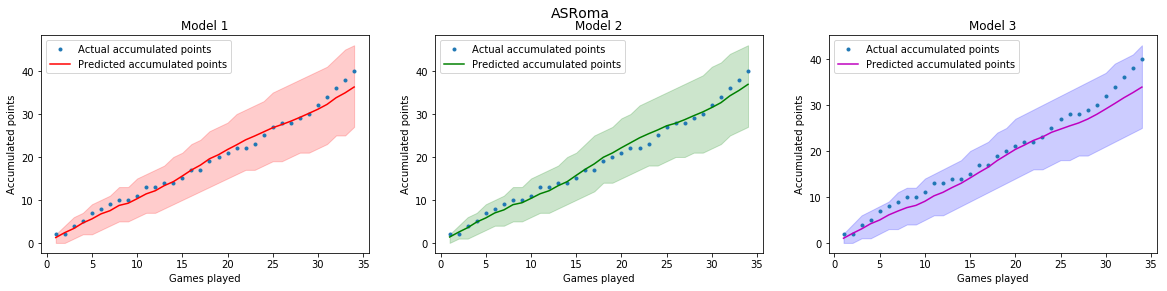

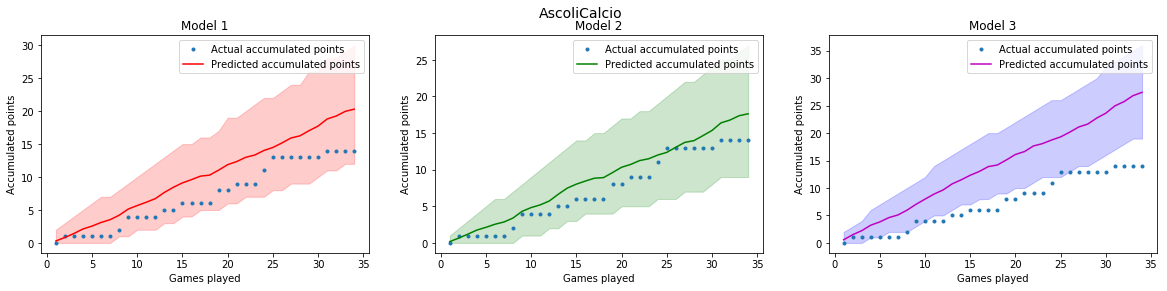

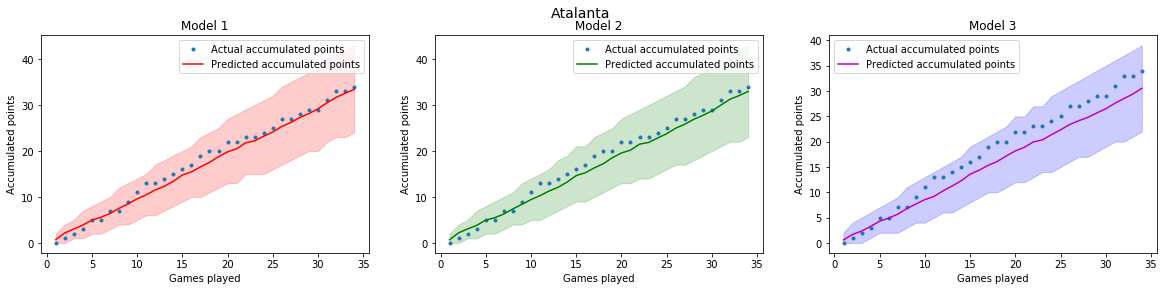

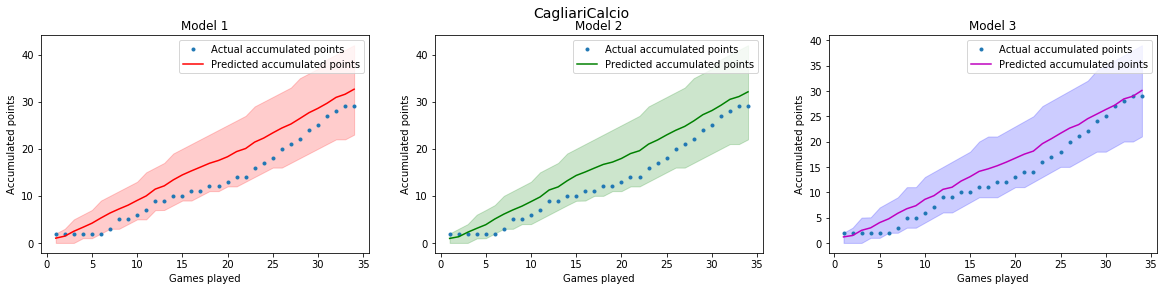

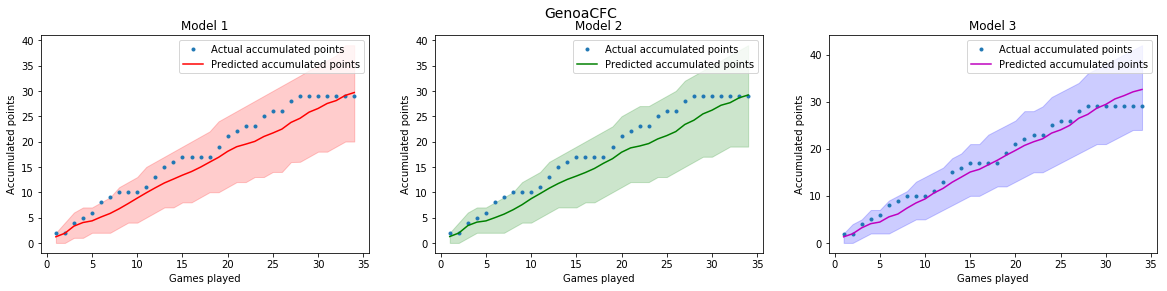

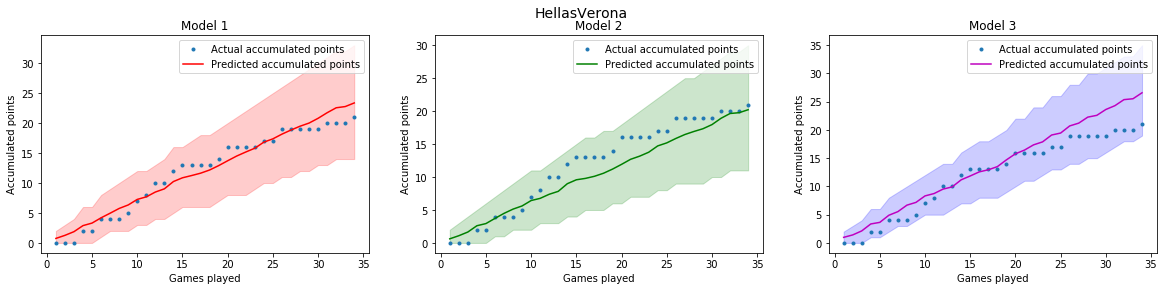

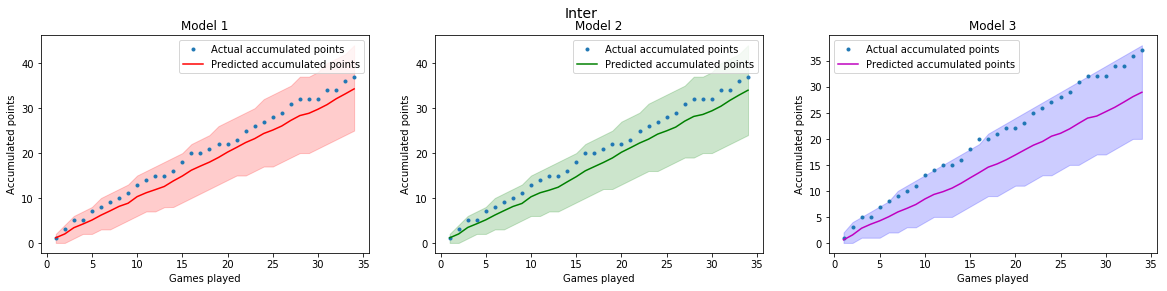

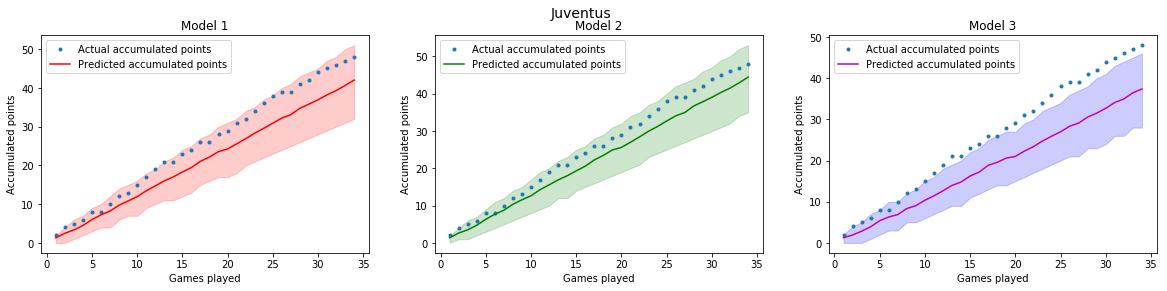

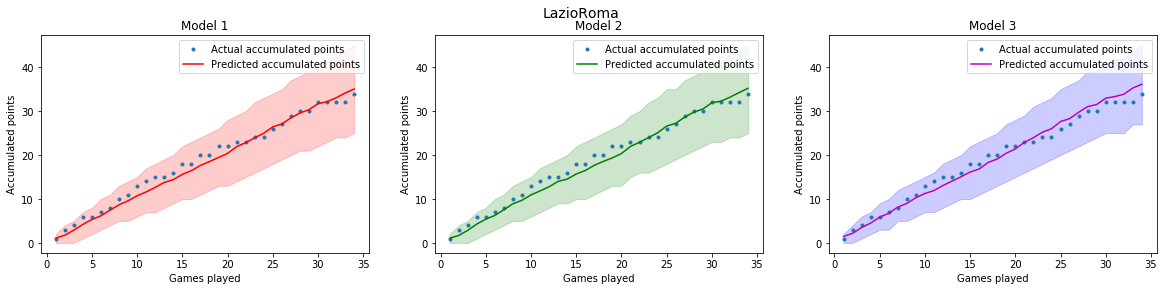

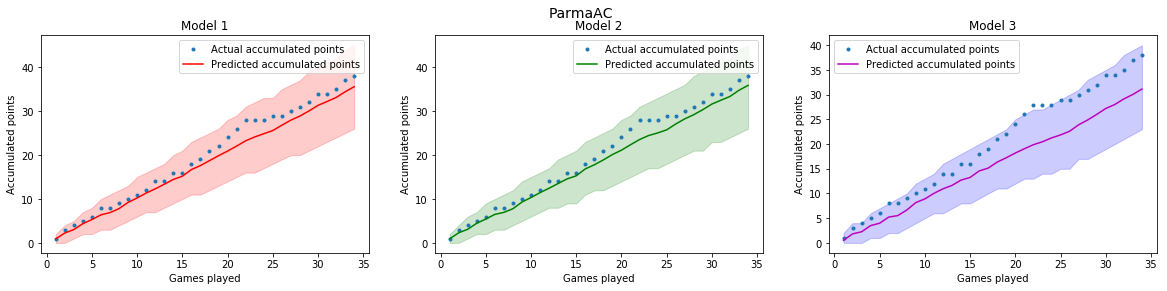

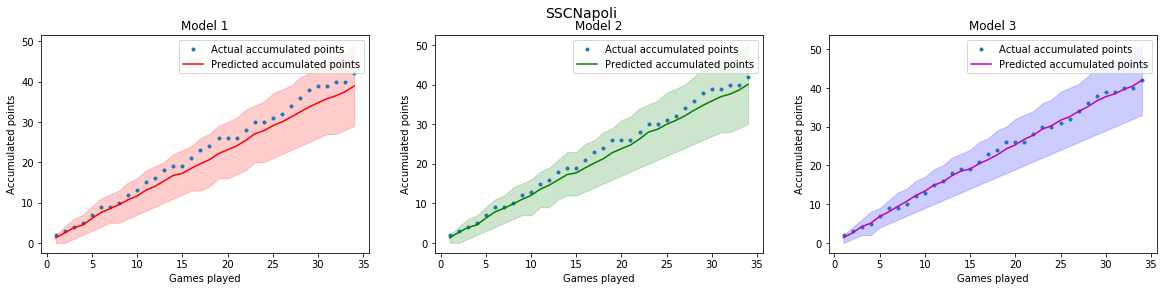

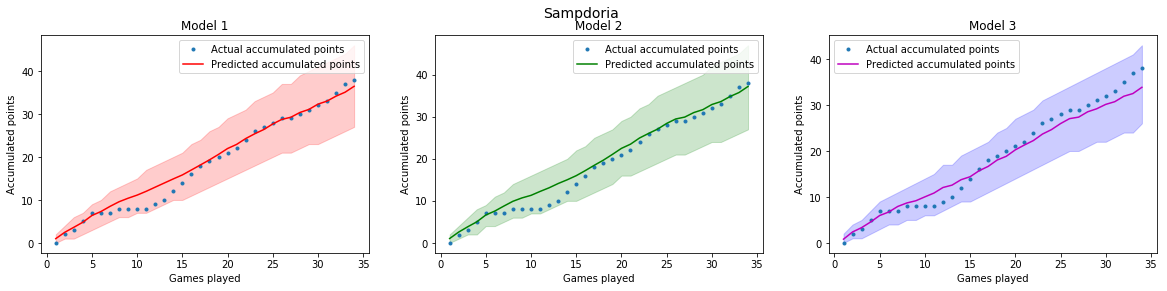

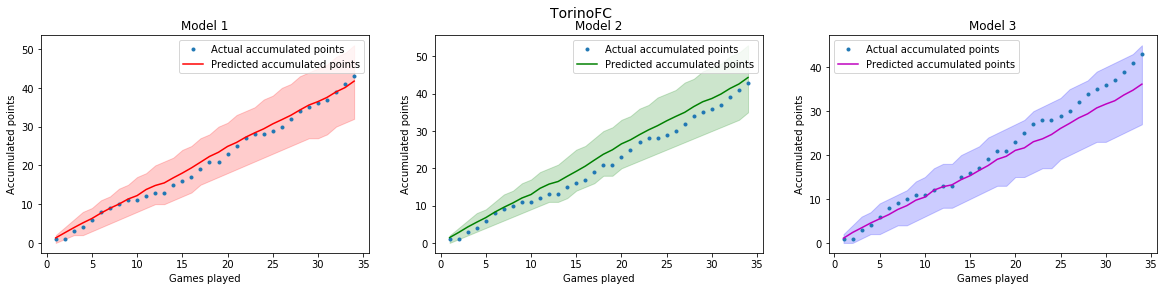

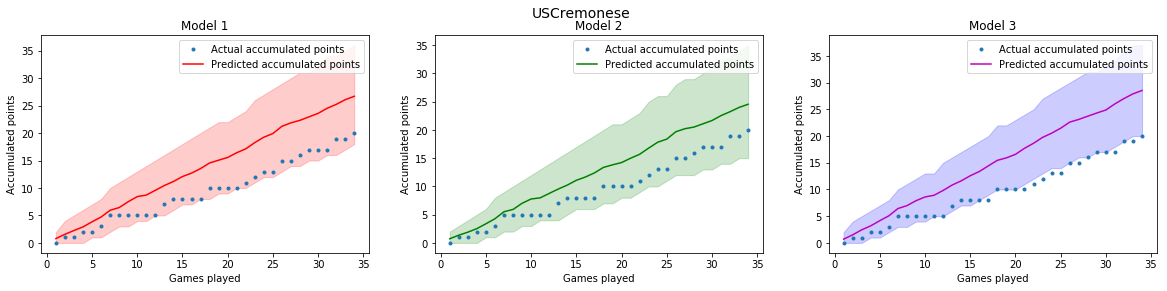

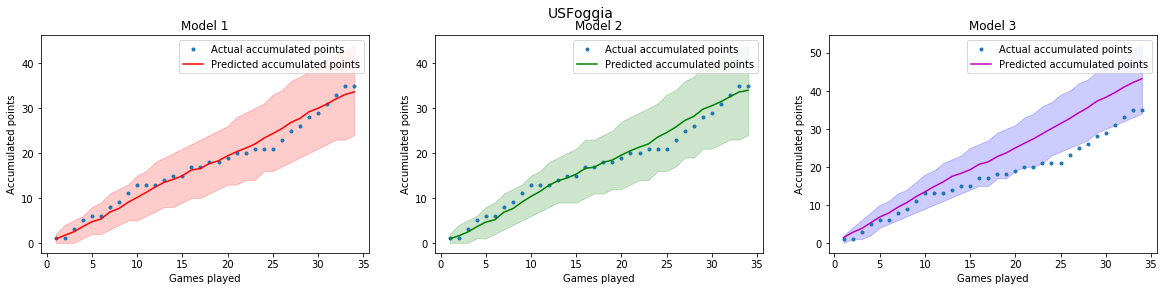

In [12]:
# Plot results

games_played = np.arange(1,N_games_per_team+1)

for i in np.arange(N_teams):
    
    f = plt.figure(figsize=(20,4))
    
    f.suptitle(ordered_teams[i], fontsize=14)
    
    
    #Model 1
    ax1 = f.add_subplot(131)
    
    #Actual score   
    ax1.plot(games_played, actual_accumulated_points[i, :], '.', label = 'Actual accumulated points')
    
    #Predictions
    ax1.plot(games_played, mean_accumulated_points1[i,:], color = 'r', label = 'Predicted accumulated points')
    plt.fill_between(games_played, lower_percentile1[i,:], upper_percentile1[i,:], color = 'r', alpha = 0.2)

    plt.xlabel('Games played')
    plt.ylabel('Accumulated points')
    plt.title('Model 1')
    plt.legend()
    
    
    
    #Model 2
    ax2 = f.add_subplot(132)
    
    #Actual score   
    ax2.plot(games_played, actual_accumulated_points[i, :], '.', label = 'Actual accumulated points')
    
    #Predictions
    ax2.plot(games_played, mean_accumulated_points2[i,:], color = 'g', label = 'Predicted accumulated points')
    plt.fill_between(games_played, lower_percentile2[i,:], upper_percentile2[i,:], color = 'g', alpha = 0.2)

    plt.xlabel('Games played')
    plt.ylabel('Accumulated points')
    plt.title('Model 2')
    plt.legend()    
    
    
    #Model 3
    ax3 = f.add_subplot(133)
    
    #Actual score   
    ax3.plot(games_played, actual_accumulated_points[i, :], '.', label = 'Actual accumulated points')
    
    #Predictions
    ax3.plot(games_played, mean_accumulated_points3[i,:], color = 'm', label = 'Predicted accumulated points')
    plt.fill_between(games_played, lower_percentile3[i,:], upper_percentile3[i,:], color = 'b', alpha = 0.2)
    
    plt.xlabel('Games played')
    plt.ylabel('Accumulated points')
    plt.title('Model 3')
    plt.legend()
    
    plt.show()

## Comparison of PSIS-LOO values
Having compared the predictive performance of the models on the Italy Series A 1991-1992, we now turn to a more quantitative comparison by the use of leave-on-out (LOO-CV) cross-validation. Concretely we use the the script psis.py (found in the Github repository of this project), which calculates a LOO-CV score for each model using Pareto-smooted importance sampling [2] and also computes k-values, which can be used to verify the validity of the LOO-CV estimate. Finally we also also calculate the effective number of parameters for each model based on the equations (7.5) and (7.15) in Bayesian Data Analysis [3]. The cells below print the LOO-CV score and effective number of parameters for each model and plots their k-values. 
From the plot it can be seen that the k-values all fall below 0.5 indicating reliability of the LOO-CV estimates. The best model, as indicated by the LOO-CV score, is the hierarchical Poisson model with a value of -805.07. However, this is only slightly larger than the LOO-CV score for the non-hierarchical Poisson model, indicating that not a lot is gained through the use of a higher level of hyperparameters. Model 3 performs significantly worse than both model 1 and 2 as indicated by a LOO-CV score of -840.05. Comparing the effective parameters, we see that model 1 appears to have the lowest number of effective parameters with a value of ~22, followed by a value of ~28 for model 2 and finally ~36 for model 3. The latter is consistent with the fact that model 3 has 36 free parameters (2 values of $\theta_{tj}$ for each of the 18 teams), which once again verifies a correct model implementation.



### Hierarchical Poisson model

In [13]:
#Effective number of parameters for model 1
log_lik_model1 = fit_model1.extract('log_lik')['log_lik']
model1_loo, model1_loos, model1_k = psisloo(log_lik_model1)
print('Model 1 LOO-CV score is:', model1_loo)

#Effective sample size computed based on eq. (7.5) and (7.15) in BDA
S = log_lik_model1.shape[0]
lppd = np.sum(np.log(1/S*np.sum(np.exp(log_lik_model1),axis=0)))
peff = lppd - model1_loo
print('Effective number of parameters for model 1 is:', peff)

Model 1 LOO-CV score is: -805.0687692463745
Effective number of parameters for model 1 is: 21.98377845603102


### Non-hierarchical Poisson model

In [14]:
#Effective number of parameters for model 2
log_lik_model2 = fit_model2.extract('log_lik')['log_lik']
model2_loo, model2_loos, model2_k = psisloo(log_lik_model2)
print('Model 2 LOO-CV score is:', model2_loo)

#Effective sample size computed based on eq. (7.5) and (7.15) in BDA
S = log_lik_model2.shape[0]
lppd = np.sum(np.log(1/S*np.sum(np.exp(log_lik_model2),axis=0)))
peff = lppd - model2_loo
print('Effective number of parameters for model 2 is:', peff)

Model 2 LOO-CV score is: -808.1138931153382
Effective number of parameters for model 2 is: 27.84037816624391


### Simple Poisson model

In [16]:
log_lik_model3 = fit_model3.extract('log_lik')['log_lik']
model3_loo, model3_loos, model3_k = psisloo(log_lik_model3)
print('Model 3 LOO-CV score is:', model3_loo)


#Effective sample size computed based on eq. (7.5) and (7.15) in BDA
S = log_lik_model3.shape[0]
lppd = np.sum(np.log(1/S*np.sum(np.exp(log_lik_model3),axis=0)))
peff = lppd - model3_loo
print('Effective number of parameters for model 3 is:', peff)

Model 3 LOO-CV score is: -840.0476091434875
Effective number of parameters for model 3 is: 35.65859169998316


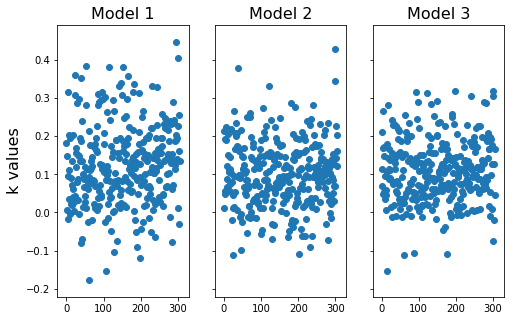

In [17]:
#Plot k-values for the three models
fig, axes = plt.subplots(1, 3, figsize=(8,5), sharex=True, sharey=True)
axes[0].scatter(range(len(model3_k)), model3_k)
axes[0].set_title("Model 1", FontSize = 16)
axes[0].set_ylabel('k values', FontSize = 16)
axes[1].scatter(range(len(model2_k)), model2_k)
axes[1].set_title("Model 2", FontSize = 16)
axes[2].scatter(range(len(model1_k)), model1_k)
_ = axes[2].set_title("Model 3", FontSize = 16)
fig.savefig('k-values.png')

## 7. Conclusion
We have studied the predictive performance of a hierarchical Poisson model for predicting football scores as suggested by [1]. The model was compared to two similar models, which contained additional simplications. The comparison was made both through assesing the predictive performance of the models on the Italy Series A 1991-1992 as well as by the use of leave-one-out cross-validation. It was found that the hierarchical Poisson model performed only slightly better than a simpler non-hierarchical Poisson model and substantially better than an even more simplified model, which neglected interactions between specific teams. 

## 8. References

[1] Baio, D., & Blangiardo, M. (2010). Bayesian hierarchical model for the prediction of football results. Journal of Applied Statistics, 2, 253-264.
     
[2] Vehtari, A., Gelman, A., & Gabry, J. (2016). Practical Bayesian model evaluation using leave-one-out cross-validation andWAIC

[3] A. Gelman, J. B. Carlin, H. S. Stern, D. B. Dunson, A. Vehtari, D. B.
Rubin. Bayesian Data Analysis. Chapman & Hall/CRC, third edition, 2013.